In [1]:
%load_ext autoreload
%autoreload 2
import os
from awesome.run.awesome_config import AwesomeConfig
from awesome.run.awesome_runner import AwesomeRunner
from awesome.dataset.awesome_dataset import AwesomeDataset
from awesome.util.reflection import class_name
import os
import torch
from awesome.run.functions import plot_dense_image_mask
from awesome.dataset.sisbosi_dataset import SISBOSIDataset, ConvexityDataset as SISBOSIConvexityDataset
from awesome.dataset.convexity_segmentation_dataset import ConvexitySegmentationDataset
from awesome.measures.awesome_loss import AwesomeLoss
from awesome.measures.regularizer_loss import RegularizerLoss
from awesome.model.convex_diffeomorphism_net import ConvexDiffeomorphismNet
from awesome.model.net import Net
import awesome
from awesome.util.path_tools import get_project_root_path
import copy
from awesome.util.torch import TensorUtil
from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset, FBMSSequenceSample
import matplotlib.pyplot as plt

os.chdir(get_project_root_path()) 

/work/ws-tmp/js267086-awesome/AWESOME/awesome/agent/torch_agent.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
2023-11-07 09:20:47.752625: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 09:20:47.752708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 09:20:47.752730: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-07 09:20:47.759743: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is o

## Moving hdf5 files

Moves the content of hdf5 files into the directory of the corresponding sequence.
THis is needed for the train set, if the we dont have tracks file and hdf5 files of amir should be reused.

In [2]:
#assert False, "Stop here"

import h5py
from tqdm.autonotebook import tqdm
from awesome.run.functions import save_mask
# Code for extracting the trajectories into the dataset folder
tracks_path = "data/local_datasets/FBMS-59/labels_with_uncertainty_flownet2_based" # Point this to the unpacked labelsUncertFbms.tar file
dataset_dirs = "data/local_datasets/FBMS-59/train/" # This to the training folder of fbms dataset
import numpy as np

import shutil
algo_name = "labels_with_uncertainty_flownet2_based"

# This will need approx 6 - 7 mins

for folder in tqdm(os.listdir(tracks_path), desc="Processing Folders"):
    complete_track_path = os.path.join(tracks_path, folder)
    h5_files = list(os.listdir(complete_track_path))

    target_path = os.path.join(dataset_dirs, folder, "weak_labels", algo_name)
    os.makedirs(target_path, exist_ok=True)
    confidence = None
    for h5_file in h5_files:
        if '.h5' not in h5_file:
            continue
        path = os.path.join(complete_track_path, h5_file)
        name = h5_file.split(".")[0]
        with h5py.File(path, "r") as f:
            # 0 = background, 1 = foreground, -1 = no label
            weak_label = np.asarray(f["img"]).T
            confidence = np.asarray(f["confidence"]).T
        
        mask = np.zeros_like(weak_label, dtype=np.uint8)
        mask[weak_label == 0] = 255
        mask[weak_label == 1] = 1
        save_mask(mask, os.path.join(target_path, f"{name}.png"))
        
        with h5py.File(os.path.join(target_path, f"{name}_confidence.h5"), "w") as f:
            f['confidence'] = confidence


/tmp/ipykernel_11664/4160028398.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  weak_label = np.asarray(f["img"]).T
/tmp/ipykernel_11664/4160028398.py:30: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  confidence = np.asarray(f["confidence"]).T


Loading frames...:   0%|          | 0/4 [00:00<?, ?it/s]

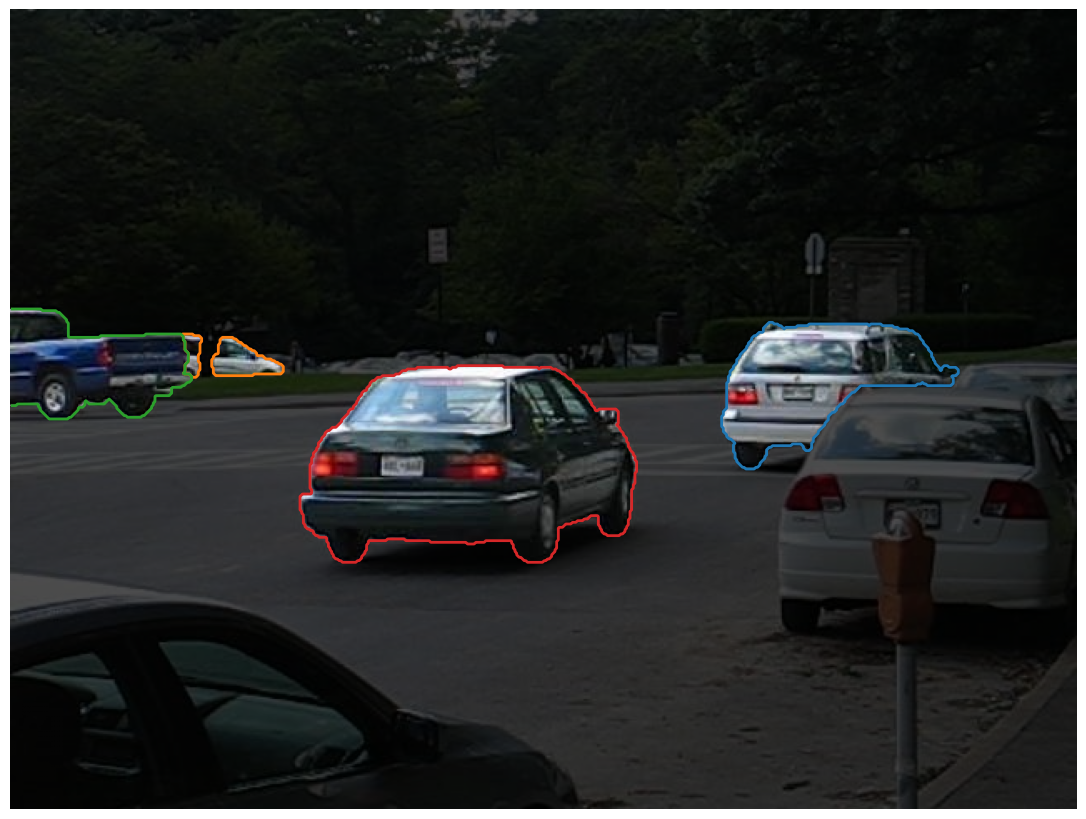

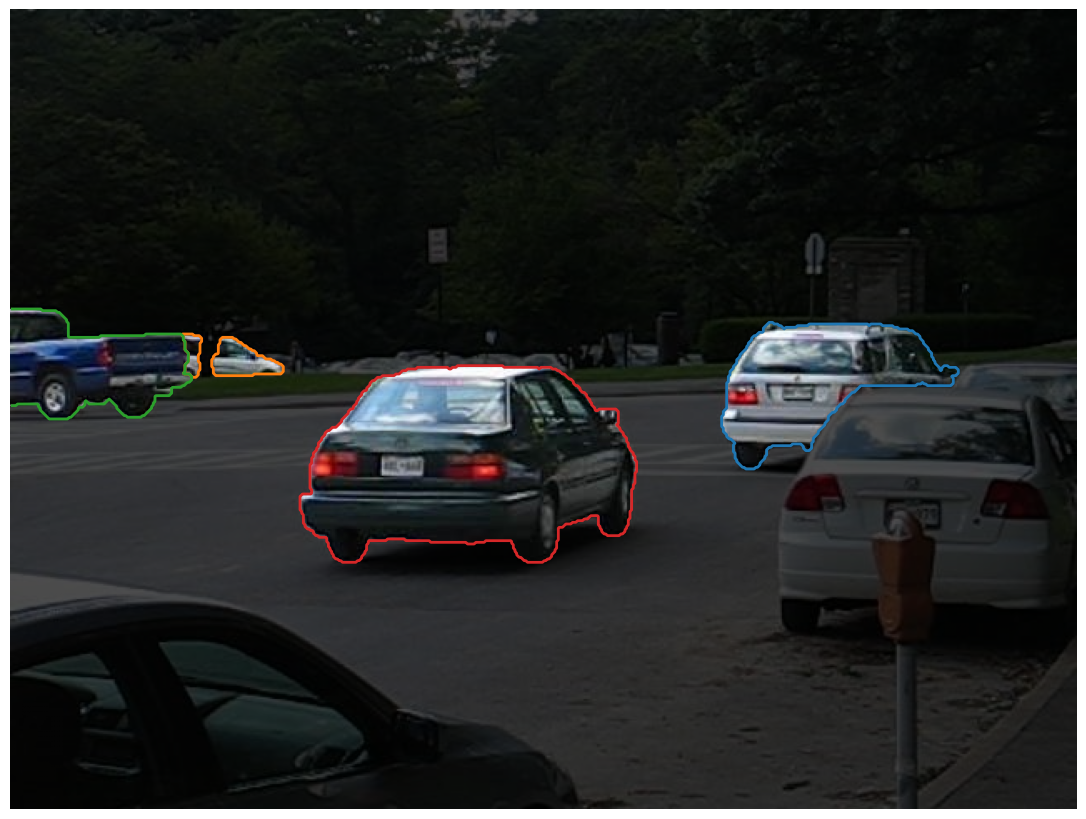

In [4]:

from awesome.dataset.fbms_sequence_dataset import FBMSSequenceDataset, FBMSSequenceSample
data_path = "./data/local_datasets/FBMS-59/train/cars2/"
dataset = FBMSSequenceDataset(
    data_path, 
    weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based",
    processed_weak_labels_dir = "weak_labels/labels_with_uncertainty_flownet2_based/processed",
    all_frames=False)

index = 0
dataset[index].plot()

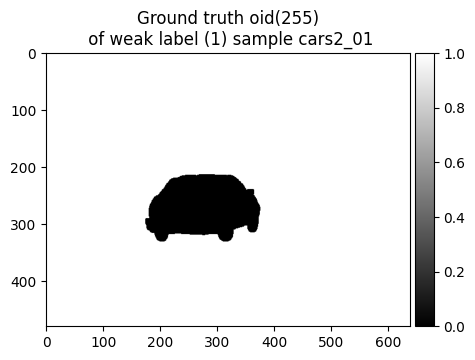

In [23]:
from awesome.run.functions import plot_as_image

index = 0

# Dataset contains all labeled samples where we need metrics for
sample = dataset[index]

#
# Label is the ground truth
plot_as_image(sample.label, variable_name=f"Ground truth oid({sample.foreground_gt_object_id})\n of weak label ({sample.foreground_weak_label_object_id}) sample {sample.feat_name}", colorbar=True)

In [24]:
# Ground truth format: 1 = background, 0 = foreground
# Need to be inverted for mIoU => 1 = foreground, 0 = background
sample.label

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])